# Regulome Explorer Notebook - Gene Expression

This notebook computes associations between Gene expression of a list of genes and other molecular features available in TCGA BigQuery tables. The specific statistical tests used between Gene expression and the molecular features (Molecular feature 2) are described in the following table. 

|Molecular feature 2  |Data type  | Statistics     |
|:---                 |:---       |         ---------- : |
|Gene expression      |numerical  | Spearman Correlation |
|Somatic Copy number  |numerical  | Spearman Correlation |
|Clinical numerical   |numerical  | Spearman Correlation |
|Somatic mutation Spearman  |binary     | Spearman Correlation           |
|Somatic mutation t-test    |binary     | T-score           |
|Clinical categorical |categorial | Kruskal-Wallis score (H)      |

The output of the notebook is a table sorted by association scores, so that strongest associations between Gene expression and the user specified molecular feature is  displayed at the top of the resulting table.

This notebook also performs a more detailed analysis from a user specified pair of features names (genes, mutation, clinical annotations, etc.). The analysis includes the computation of p-values, additional statistics, and figures in a similar style than Regulome explorer.

### Authentication
The first step is to authorize access to BigQuery and the Google Cloud. For more information see ['Quick Start Guide to ISB-CGC'](https://isb-cancer-genomics-cloud.readthedocs.io/en/latest/sections/HowToGetStartedonISB-CGC.html) and alternative authentication methods can be found [here](https://googleapis.github.io/google-cloud-python/latest/core/auth.html).

### Import Python libraries

In [224]:
#%load_ext autoreload
#%autoreload 2
from google.cloud import bigquery
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import ipywidgets as widgets
import re_module.bq_functions as regulome

### Specify Parameters
The parameters for this experiment are the cancer type (study), a list of genes, a molecular feature that will be compared with gene expression, and the minimum number of samples required for the statistical analysis. 

In [225]:
[study, feature2_name, gene_names, size] = regulome.makeWidgets()

### Build Bigquery string
The Bigquery to compute associations between gene expression and 'molecular feature' is composed of the following four tables: 
  - The first table contains Gene Expression data from user list of gene names
  - The second table contains data of the molecular feature 2. 
  - The third table is a combination of tables 1 and 2 
  - The fourth table contains final statistics

In [226]:
query_table1= """
table1 AS (
SELECT  symbol, data, ParticipantBarcode,
        (RANK() OVER (PARTITION BY symbol ORDER BY data ASC)) + (COUNT(*) OVER ( PARTITION BY symbol, CAST(data as STRING)) - 1)/2.0 AS rnkdata 
FROM ( 
   SELECT 
         Symbol AS symbol, AVG( LOG10( normalized_count + 1 )) AS data, ParticipantBarcode,
         COUNT( SampleBarcode)  as nsample 
   FROM  `pancancer-atlas.Filtered.EBpp_AdjustPANCAN_IlluminaHiSeq_RNASeqV2_genExp_filtered` 
   WHERE Study = '{0}' AND Symbol in UNNEST(@PARAMETERLIST) AND normalized_count IS NOT NULL
   GROUP BY 
         ParticipantBarcode, symbol
   )
   
)
""".format( study.value )

The following tables are specific to the selected molecular feature, and are created using functions in the 'regulome' module. The final query ('sql') can be printed and modified for other applications 

In [227]:
query_table2 = regulome.get_feature2_table( study.value, feature2_name.value )
str_summarized = regulome.get_summarized_table( 'Gene Expression',feature2_name.value  )
str_stats = regulome.get_stat_table( feature2_name.value, size.value )

sql = ( 'WITH' + query_table1 + ',' + query_table2 + ',' + str_summarized + str_stats)
#print(sql)

### Run the Bigquery

In [228]:
bqclient = bigquery.Client()
gene_list = [ x.strip() for x in gene_names.value.split(',') ]
df_results = regulome.runQuery ( bqclient, sql, gene_list , dryRun=False )



 in runQuery ... 
    this query processed 7828848022 bytes 
    Approx. elpased time : 22508 miliseconds 


In [229]:
df_results[0:10]

,symbol1,symbol2,n_1,n_0,avg1,avg0,tscore
0,IGF2,ADCY6,30,510,2.528557,3.232999,8.646479
1,ADAM6,TTC14,35,505,4.563166,3.720492,7.637177
2,IGF2,PHACTR4,31,509,2.639206,3.227644,7.267107
3,ADAM6,PHLPP1,36,504,4.437801,3.727775,7.190469
4,IGF2,ASPM,70,470,2.723918,3.263855,7.078710
5,IGF2,PRRC2A,40,500,2.661358,3.236464,7.068822
6,ADAM6,PLXNB3,51,489,4.339592,3.716238,7.028194
7,ADAM6,SYNJ1,42,498,4.374923,3.724523,6.994572
8,IGF2,OBSCN,108,432,2.817412,3.287976,6.936299
9,ADAM6,CHD7,59,481,4.315077,3.708877,6.932297


## Analyze a pair of features
From the table above please select a pair of features names to perform a statitical analysis and display the data. You can print the variable 'pair_query' to obtain the query used to retrieve the data. 

In [220]:
[name1 , name2 ] = regulome.makeWidgetsPair()

In [230]:
pair_query = regulome.get_query_pair(name1.value,name2.value,study.value,'Gene Expression',feature2_name.value)

In [231]:
df_pair = regulome.runQuery( bqclient, pair_query, [] , dryRun=False )


 in runQuery ... 
    the results for this query were previously cached 


                       ADAM6 (gene expression)      
                                          mean count
HLX (Somatic Mutation)                              
0                                     3.750624   521
1                                     4.446533    19

T-test statistics : 
Ttest_indResult(statistic=-9.119885921394625, pvalue=2.557011683315096e-10)


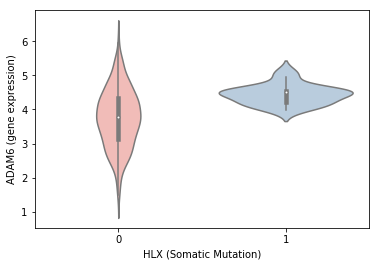

In [232]:
regulome.plot_statistics_pair ( df_pair, feature2_name.value, name1.value, name2.value, size.value )  